In [1]:
# Import all libraries and linked files require to process the required Machine Learning Algorithms
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import time
import pandas as pd
from scipy.stats import zscore
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import argparse
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras import Sequential
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC

In [2]:
#Helper functions - Provided throughout all the lectures in RBE595ST AV

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].to_numpy(np.float32), dummies.to_numpy().astype(np.float32)
    else:
        # Regression
        return df[result].to_numpy(np.float32), df[target].to_numpy(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()    

In [3]:
# Start tracking the time requirements for execution
Start = time.time()

# Find the data files that are required for this Machine Learning Algorithm. These have been provided and obtained from Kaggle (https://www.kaggle.com/gloseto/traffic-driving-style-road-surface-condition)
peugot_1 = ".\Data\peugeot_207_01.csv"
peugot_2 = ".\Data\peugeot_207_02.csv"
df_corsa_1 = ".\Data\opel_corsa_01.csv"
df_corsa_2 = ".\Data\opel_corsa_02.csv"

# Set the number of epoches to train against
N = 10000 #Epochs


In [4]:
# Load up all the data files and concatenate into the one dataframe
df_peugot_1 = pd.read_csv(peugot_1, delimiter=';')
df_peugot_2 = pd.read_csv(peugot_2, delimiter=';')

df_corsa_1 = pd.read_csv(df_corsa_1, delimiter=';')
df_corsa_2 = pd.read_csv(df_corsa_2, delimiter=';')

df_combined = pd.concat([df_peugot_1, df_peugot_2, df_corsa_1, df_corsa_2], axis=0)

# Update the values for the purposes of this Machine Learning Algorithm and Project
df_combined['roadSurface'] = df_combined['roadSurface'].replace(to_replace='FullOfHolesCondition', value='Damaged')
df_combined['roadSurface'] = df_combined['roadSurface'].replace(to_replace='SmoothCondition', value='Driveable')
df_combined['roadSurface'] = df_combined['roadSurface'].replace(to_replace='UnevenCondition', value='Caution')

# Encode targets and sources
targets=encode_text_index(df_combined,'roadSurface')
df_combined = df_combined.drop(['drivingStyle','traffic'], axis = 1)

# Getting the list of column headers
col_headers = list(df_combined)

# Normalize all numerics to zscores and all text/categoricals to dummies
# If you find any missing values (NA's), replace them with the median values for that column.
count = 0
for element in col_headers:
    if element not in ['roadSurface']:
        missing_median(df_combined,element)
        encode_numeric_zscore(df_combined, element)        

# Shuffle the dataset
df_combined = shuffle(df_combined)

# Your target (y) is the filed named target.
x_train, y_train = to_xy(df_combined,'roadSurface')

# Set up the training parameters and configurations for learning
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit(x_train)

x_train = min_max_scaler.transform(x_train)
x_test = min_max_scaler.transform(x_test)

In [5]:
#Run the Machine Learning Model\
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(128))
model.add(Dropout(0.05))
model.add(Dense(16))
model.add(Dense(4, 
            kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01),activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Set up controls to stop learnign if the value loss goes in the negative direction, and keep saving as it runs
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
H = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=N,callbacks=[monitor,checkpointer])

# Rever to the best model at the conclusion of the training run
model.load_weights('best_weights.hdf5') # load weights from best model      

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 19965 samples, validate on 4992 samples
Epoch 1/10000
19965/19965 [==============================] - 4s 202us/sample - loss: 0.6872 - val_loss: 0.5775
Epoch 2/10000
19965/19965 [==============================] - 3s 153us/sample - loss: 0.5356 - val_loss: 0.4868
Epoch 3/10000
19965/19965 [==============================] - 3s 160us/sample - loss: 0.4712 - val_loss: 0.4354
Epoch 4/10000
19965/19965 [==============================] - 4s 182us/sample - loss: 0.4390 - val_loss: 0.4133
Epoch 5/10000
19965/19965 [==============================] - 4s 176us/sample - loss: 0.4169 - val_loss: 0.3905
Epoch 6/10000
19965/19965 [==============================] - 3s 152us/sample - loss: 0.3959 - val_loss: 0.4028
Epoch 7/10000
19965/19965 [==============================] - 3s 157us/sample - loss: 0.3831 - val_loss: 0.3489
Epoch 8/10000
19965/19965 [==============================] - 3s 153us/sample - loss: 0.3731 -

In [6]:
# Find the prediction score based on the model developed amd output it to the user
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_compare, pred)
print("Final accuracy: {}".format(score))

End = time.time()
print(End - Start)

Final accuracy: 0.9387019230769231
127.51335430145264


Confusion matrix, without normalization
Normalized confusion matrix


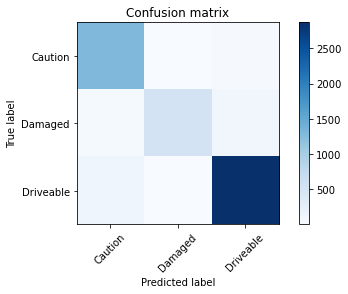

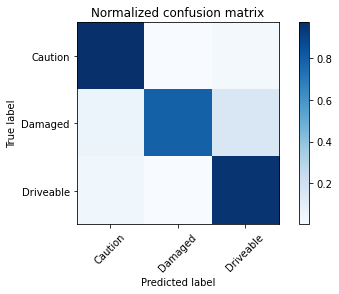

In [7]:
# Compute confusion matrix to determine the level of accuracy achieved. This has been re-run several times to tweak parameters to get the optimal outcome
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm, targets)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, targets, title='Normalized confusion matrix')

plt.show()
